In [2]:
import pandas as pd
import numpy as np
import matplotlib_venn as mv


df_original = pd.read_csv("contrib_from_original.csv", sep = ",", dtype= str)
df_processed = pd.read_csv("contrib_from_csv.csv", sep = ",", dtype= str)

#  affiche la totalité du dataframe (seulement pour les df de petite taille)
def print_full(df):
    import pandas as pd
    pd.set_option('display.max_rows', len(df))
    print(df)
    pd.reset_option('display.max_rows')

print(df_original.isna().any()) # aucune NA dans l'original
print(df_processed.isna().any()) # codes postal et type graphie ont des NA dans le processed

# affiche toutes les lignes contenant des NaN
# print_full(df_processed[df_processed.isna().any(axis=1)])
# affiche la somme des NaN
print(df_processed["Code postal"].isnull().sum)



Unnamed: 0           False
filename             False
nb_of_file           False
xml                  False
categorie_region     False
info_communes        False
Catégorie            False
Code postal          False
Date de réception    False
Code INSEE           False
Type Graphie TT      False
Numéro d'id_cc       False
dtype: bool
Catégorie                    False
Date de réception            False
Code postal                  False
Code INSEE                   False
Numéro d'ordre arbitraire    False
Type Graphie TT              False
Numéro de page               False
Numéro séquentiel            False
Contribution                 False
joined_id                    False
dtype: bool
<bound method NDFrame._add_numeric_operations.<locals>.sum of 0         False
1         False
2         False
3         False
4         False
          ...  
225040    False
225041    False
225042    False
225043    False
225044    False
Name: Code postal, Length: 225045, dtype: bool>


In [3]:
# testé : AUCUN DUPLICATE

# AFFICHER les types d'element des df et leur taille:
# print("XML :\n", df_original.sample(3))
print ("xml", df_original.dtypes)
# print("XML shape :\n", df_original.shape)
# print("csv", df_processed.dtypes)
# print("CSV shape :\n",df_processed.shape)
# print("CSV :\n", df_processed.sample(3))

# test sur un seul ID :
# print(df_processed.loc[df_processed["joined_id"] == "CC_70000_190225_70163_MD_06225"])

xml Unnamed: 0           object
filename             object
nb_of_file           object
xml                  object
categorie_region     object
info_communes        object
Catégorie            object
Code postal          object
Date de réception    object
Code INSEE           object
Type Graphie TT      object
Numéro d'id_cc       object
dtype: object


In [4]:

# compte le nombre de contribution pour chaque id de.. carnet? pour avoir le même niveau que le pandas des originaux AN
group1 = pd.DataFrame({'count' : df_processed.groupby( ["joined_id"] ).size()}).reset_index()


print(df_processed.sample(2))

       Catégorie Date de réception Code postal Code INSEE  \
134333        CC            190226       69700      69118   
115523        CC            190225       22560      22198   

       Numéro d'ordre arbitraire Type Graphie TT Numéro de page  \
134333                     09068              MD             12   
115523                     10853              MD             25   

       Numéro séquentiel                                       Contribution  \
134333                 2  . DÉPARTEMENT :\nle département préside les ac...   
115523                 2  Yves Lafaye\n14 Chemin de la Butte 22560 Pleum...   

                             joined_id  
134333  CC_69700_190226_69118_MD_09068  
115523  CC_22560_190225_22198_MD_10853  


In [5]:
df_original = df_original.rename(columns={"info_communes": "joined_id"})
df_original = df_original.rename(columns={"Numéro d'id_cc": "Numéro d'ordre arbitraire"})

# merge sur les noms de dossiers
mergedStuff = pd.merge(df_original, group1, left_on=["joined_id"], 
               right_on=["joined_id"],
            #    on=['joined_id'], 
                how='outer', indicator=True)

# original qui n'existe pas dans processed (noms de dossiers)
left_only = mergedStuff.loc[mergedStuff["_merge"] == "left_only"]
# processed qui n'existe pas original (noms de dossiers)
right_only = mergedStuff.loc[mergedStuff["_merge"] == "right_only"]

# taille des différences
print("left_only.shape", left_only.shape)
print("right_only.shape", right_only.shape)

left_only.shape (855, 14)
right_only.shape (1317, 14)


In [6]:
# cree une colonne DEPARTEMENTS pour les datas processed en prenant les deux premiers chiffres du code postal
df_processed["departement"] = df_processed["Code postal"].astype(str).str[:2]
print(df_processed["departement"])

# pour les communes qui ne partagent pas leur n° de département avec leur insee, j'utilise le même classement que l'original AN (code postal > code insee). vu dans le test suivant :
# print(df_original.loc[df_original["Code INSEE"] == '04058'])
# print(df_original.loc[df_original["Code postal"] == '05110'])

# cree une colonne departement pour les datas AN à partir du code postal aussi
df_original["departement"] = df_original["Code postal"].astype(str).str[:2]

0         00
1         00
2         00
3         00
4         00
          ..
225040    97
225041    97
225042    97
225043    97
225044    97
Name: departement, Length: 225045, dtype: object


In [27]:
# choix de la variable à observer :
# nos variables d'interêt : "Code INSEE", "departement", "Numéro d'ordre arbitraire" (arbitraires valent seulmt pour notre corpus)
info_recherche = ["Code INSEE", "departement", "Numéro d'ordre arbitraire"]
noms = ["Communes", "Département", "Carnets (numéro d'ordre arbitraire)"]
choix = 2

# compte le nombre de contributions pour chaque code
processed_groupdf = df_processed.groupby([info_recherche[choix]]).size().reset_index()
print("GROUPBY processed SAMPLE seulement\n",processed_groupdf.sample(1))

# merge outer entre processed et original selon les codes (commune ou insee)
uniques_original = pd.DataFrame(pd.unique(df_original[info_recherche[choix]]), columns=[info_recherche[choix]]).reset_index(drop=True)
print("uniques_original.shape : ",uniques_original.shape)
uniques_processed = pd.DataFrame(pd.unique(df_processed[info_recherche[choix]]), columns=[info_recherche[choix]]).reset_index(drop = True)
print("uniques_processed.shape : ",uniques_processed.shape)
merge_df = pd.merge(uniques_original, uniques_processed, on=[info_recherche[choix]], how='outer', indicator='source')
# NOTE : ceux la peuvent être comparer entre eux car ils sont le même type d'objet

# fait deux merge, un sur le outer left et un sur le outer right pour récup les codes exclus chacuns par l'autre
dict_of_df = {}
for i in [0,1] :
    mer = ["left_only", "right_only"]
    nam = ["original", "derivé csv"]
    result = merge_df[merge_df.source.eq(mer[i])].drop('source', axis=1)
    print("MERGE result shape : "+nam[i], result.shape)
    print("MERGE result sample 10 : "+nam[i], "\n")

    # result.to_csv(noms[choix]+"_seulement_dans_"+nam[i]+"_pour_original_vs_processed", columns=[info_recherche[choix]], index = False)


GROUPBY processed SAMPLE seulement
      Numéro d'ordre arbitraire  0
1534                     01803  1
uniques_original.shape :  (18854, 1)
uniques_processed.shape :  (19250, 1)
MERGE result shape : original (648, 1)
MERGE result sample 10 : original 

MERGE result shape : derivé csv (1044, 1)
MERGE result sample 10 : derivé csv 



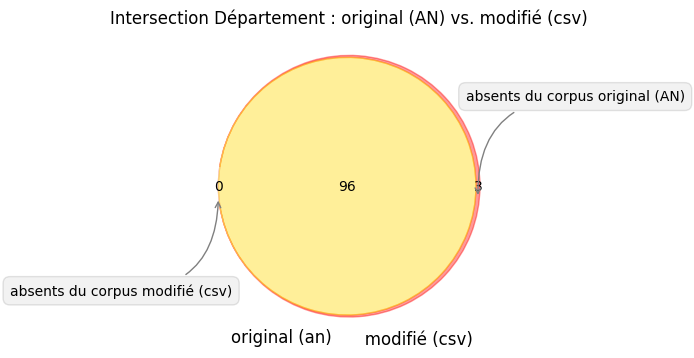

In [21]:
from matplotlib import pyplot as plt

inner_merged = pd.merge(uniques_original, uniques_processed, on=[info_recherche[choix]], how='inner', indicator='source')
# mv.venn2([set(list(dict_of_df["original"]["Code postal"])), set(list(dict_of_df["derivé csv"]["Code postal"]))])
# mv.venn2([set(list(inner_merged["Code postal"])), set(list(dict_of_df["derivé csv"]["Code postal"]))])

plt.figure(figsize=(8,4))

v = mv.venn2([set(list(df_original[info_recherche[choix]])), set(list(df_processed[info_recherche[choix]]))], set_labels= ("original (an)   ", "   modifié (csv)"))
# mêmes resultats avec :
# v = mv.venn2([set(list(uniques_original[info_recherche[choix]])), set(list(uniques_processed[info_recherche[choix]]))], set_labels= ("original (an)   ", "   modifié (csv)"))

v.get_patch_by_id('10').set_color('violet')
v.get_patch_by_id('01').set_color('red')
v.get_patch_by_id('11').set_color('gold')
plt.title("Intersection "+noms[choix]+" : original (AN) vs. modifié (csv)")
plt.annotate('absents du corpus modifié (csv)', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('absents du corpus original (AN)', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(70,70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
# plt.show(v)
plt.savefig('original_vs_modifie_dpt.png', format = "png", dpi = 800)



In [28]:
# comparaison insee stats vs. corpus processed stats

# retrieve insee datas from insee csv
# retrieve dept values only, from insee df into a df and rename the column
if choix == 0 :
    df_communes = pd.read_csv("cog_ensemble_2019_csv/communes-01012019.csv", sep = ",")
    df_insee = pd.Series(df_communes["com"], name=info_recherche[choix]).reset_index(drop = True)

else :
    df_departement = pd.read_csv("cog_ensemble_2019_csv/departement2019.csv", sep = ",")
    df_insee = pd.Series(df_departement["dep"], name=info_recherche[choix]).reset_index(drop = True)


# create a df with departement only from the processed df (csv), sort them -> they now can be used on compare with insee sheets (bc same objects types I guessed)
processed_compare_df = pd.unique(df_processed[info_recherche[choix]])
processed_compare_df = pd.Series(np.sort(processed_compare_df), name=info_recherche[choix], dtype=str).reset_index(drop = True)
shape_processed = processed_compare_df.shape
# merge the two
merged_departement = pd.merge(df_insee.astype(str), processed_compare_df.astype(str), how='outer', indicator='source')
print(uniques_processed)
# error with dataframes object : some identicals are seen as different (check or apply solution here to the previously merged files)

# compare the two series
# "Can only compare identically-labeled Series objects" : serie .compare() doit avoir le meme nombre rows
for i in [0,1] :
    mer = ["left_only", "right_only"]
    nam = ["insee", "processed"]
    result = merged_departement[merged_departement.source.eq(mer[i])].drop('source', axis=1)
    print(nam[i],"\n",  result)
    print(nam[i]," shape\n",  result.shape)

    # result.to_csv(noms[choix]+"_seulement_dans_"+nam[i]+"_pour_insee_vs_processed", columns=[info_recherche[choix]], index = False)


      Numéro d'ordre arbitraire
0                         01260
1                         01603
2                         01605
3                         01623
4                         01690
...                         ...
19245                     19241
19246                     19244
19247                     19242
19248                     19240
19249                     19330

[19250 rows x 1 columns]
insee 
     Numéro d'ordre arbitraire
0                          01
1                          02
2                          03
3                          04
4                          05
..                        ...
96                        971
97                        972
98                        973
99                        974
100                       976

[101 rows x 1 columns]
insee  shape
 (101, 1)
processed 
       Numéro d'ordre arbitraire
101                           
102                       00159
103                       00160
104                       00161
105

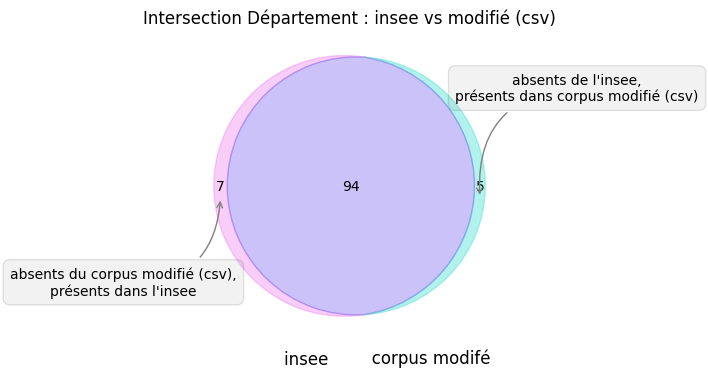

In [23]:
plt.figure(figsize=(8,4))
v = mv.venn2([set(list(df_insee)), set(list(processed_compare_df))], set_labels= ("\ninsee   ", "\n   corpus modifé"))

v.get_patch_by_id('10').set_color('violet')
v.get_patch_by_id('01').set_color('turquoise')
v.get_patch_by_id('11').set_color('mediumslateblue')


plt.title("Intersection "+noms[choix]+" : insee vs modifié (csv)")
plt.annotate('absents du corpus modifié (csv),\nprésents dans l\'insee', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('absents de l\'insee,\nprésents dans corpus modifié (csv)', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(70,70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

plt.savefig('insee_vs_modifie_dpt.png', format = "png", dpi = 1000)

#  2A et 2B = la corse 20
#  97 = les outrmer tous ensemble
#  98 et 99 = ?
#  987 = polynésie française(?) "communauté autonome rattachée à la france"
#  986 = wallis et futuna
#  984 = territoires australes
#  98000 = monaco (???)
#  988 = nouvelle calédonie

<class 'pandas.core.series.Series'>
insee 
     Numéro d'ordre arbitraire
0                          01
1                          02
2                          03
3                          04
4                          05
..                        ...
96                        971
97                        972
98                        973
99                        974
100                       976

[101 rows x 1 columns]
original 
       Numéro d'ordre arbitraire
101                       00159
102                       00160
103                       00161
104                       00162
105                       00163
...                         ...
18950                     20183
18951                     20184
18952                     20185
18953                     20186
18954                     20187

[18854 rows x 1 columns]


AttributeError: 'NoneType' object has no attribute 'set_color'

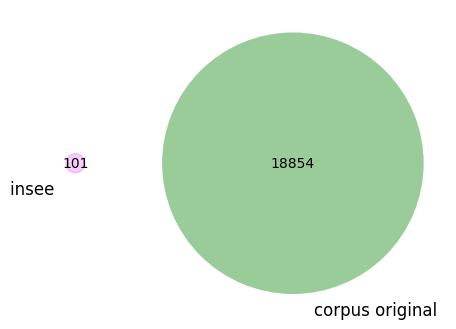

In [29]:
# comparaison insee stats vs. corpus original AN stats

compare_original = pd.unique(df_original[info_recherche[choix]])
compare_original = pd.Series(np.sort(compare_original), name=info_recherche[choix], dtype=str).reset_index(drop = True)
print(type(compare_original))
original_shape = compare_original.shape
insee_shape = df_insee.shape
# merge the two
merged_departement = pd.merge(df_insee.astype(str), compare_original.astype(str), how='outer', indicator='source')
# error with dataframes object : some identicals are seen as different (check or apply solution here to the previously merged files)

# compare the two series
# "Can only compare identically-labeled Series objects" : serie .compare() doit avoir le meme nombre rows
for i in [0,1] :
    mer = ["left_only", "right_only"]
    nam = ["insee", "original"]
    result = merged_departement[merged_departement.source.eq(mer[i])].drop('source', axis=1)
    print(nam[i],"\n",  result)

    # result.to_csv(noms[choix]+"_seulement_dans_"+nam[i]+"_pour_insee_vs_original", columns=[info_recherche[choix]], index = False)
plt.figure(figsize=(8,4))

v = mv.venn2([set(list(df_insee)), set(list(compare_original))], set_labels= ("insee    ", "    corpus original"))
v.get_patch_by_id('10').set_color('violet')
v.get_patch_by_id('11').set_color('gold')

v.get_patch_by_id('01').set_color('blue')
# v.get_patch_by_id('11').set_color('pink')
plt.title("Intersection "+noms[choix]+" : insee vs. original (an)")
plt.annotate('absents du corpus original', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('absents des données insee', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(70,70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.savefig('insee_vs_original_departement.png', format = "png", dpi = 1000)
plt.show(v)

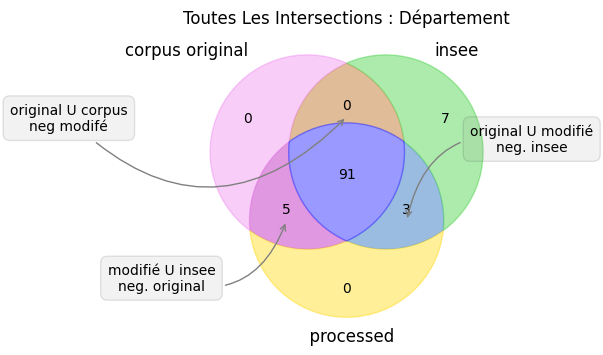

In [25]:
# processed_compare_df
# compare_original
# df_insee
plt.figure(figsize=(8,4))

v3 = mv.venn3_unweighted([set(list(compare_original)), set(list(df_insee)), set(list(processed_compare_df))], set_labels= ("corpus original  ","insee","  processed" ))
# (100, 010, 110, 001, 101, 011, 111)
v3.get_patch_by_id('100').set_color('violet')
v3.get_patch_by_id('001').set_color('gold')

v3.get_patch_by_id('111').set_color('blue')
v3.get_patch_by_id('010').set_color('limegreen')
# v3.get_patch_by_id('110').set_color('darkgreen')
plt.title("Toutes Les Intersections : "+noms[choix])
plt.annotate('original U corpus\nneg modifé', xy=v3.get_label_by_id('110').get_position() - np.array([0, 0.05]), xytext=(-200,-10),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('original U modifié\nneg. insee', xy=v3.get_label_by_id('011').get_position() - np.array([0, 0.05]), xytext=(90,50),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('modifié U insee\nneg. original', xy=v3.get_label_by_id('101').get_position() - np.array([0, 0.05]), xytext=(-90,-50),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

# plt.show()

plt.savefig('departement_all.png', format = "png", dpi = 1000)



<Figure size 800x200 with 0 Axes>

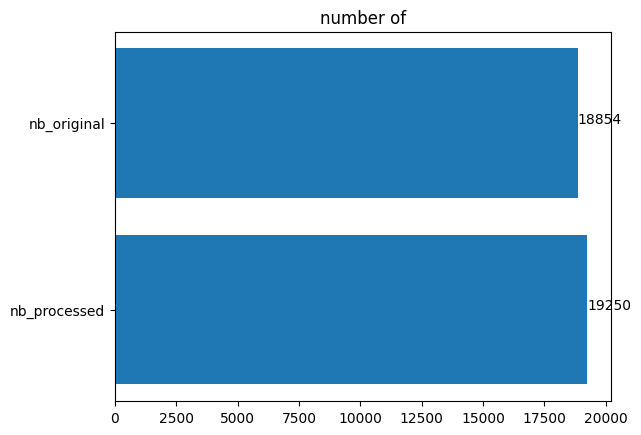

In [34]:
# values = np.array([shape_processed[0], original_shape[0], insee_shape[0]])
values = np.array([shape_processed[0], original_shape[0]])

# names = ("nb_processed", "nb_original", "nb_insee")
names = ("nb_processed", "nb_original")

plt.figure(figsize=(8,2))
fig, ax = plt.subplots()
plt.barh(names, values)
for index, value in enumerate(values):
    plt.text(value, index,
             str(value))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('number of')
plt.savefig('departement_data.png', format = "png", dpi = 1000)
plt.show()